# Redispatch Measures in Switzerland
Partially done for the udacity nanodegree for data scientists, partially done out of  interest.

### Business Understanding
Market participants try to optimise their own profit. On the other hand, power grid operaters need to keep the system stable. While at first glance this seems contradictory, redispatch measures are also payed by the market participants, hence the market already tries to avoid any redispatches all together. With the increase in renewables and political tensions between Switzerland and the EU, open source information can give information into how efficient the market is working and if there are any strucutural dificits looming. The goal of the project is track the swiss side, percived often as the weaker side of both political sides, in how often it is assisting abroad, and what kind of assistance is needed. As a data source, the project uses the [swissgrid](https://www.swissgrid.ch/de/home/customers/topics/redispatch.html) homepage and scrapes it into a .csv list. 
The .ipynb to scrape the data yourself can be found in the same folder.

To give some guidelines, I would like to answer the follopwing questions:

### Question 1: How dependant is Europe on Switzerland and vice versa?

### Question 2: How often is a redispatch performed? Is it getting worse with the energy crisis? And what plants are used?

### Question 3: Will it get worse?

### Starting the analysis
First we load all the necessary libraries used for the analysis and set the figure size for this .ipynb. It compiles all individual .csv files into one single large file.

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

import seaborn as sns
from calendar import month_name
import matplotlib.pyplot as plt, matplotlib.dates as mdates

sns.set(rc={'figure.figsize':(11.7,8.27)})

### I - Gather the data
First, we can just read the compiled .csv list of all redispatch measures from 2019 until 30.09.2022. To scrape the data, please check out scrape.ipynb

In [2]:
df = pd.read_csv('redispatch_switzerland_19_22-10-02.csv', index_col=0)

### II - Assessing the data
we can have a quick glance at the types and the genreal structure. We notice that the dataset is relatively small. all columns are objects. The dates are unevenly spread out, hence may need some resampling later on to plot and analyse it. Each event contains the type ("Beschreiung"), the start ("von") and end ("Bis"), the direction ("Richtung), the responsible unit ("EZE"), and the Energy ("Energie").

In [3]:
df.dtypes

Datum           object
Beschreibung    object
Von             object
Bis             object
EZE             object
Richtung        object
Energie         object
dtype: object

In [4]:
df.head()

,Datum,Beschreibung,Von,Bis,EZE,Richtung,Energie
0,2019-01-04,Internationaler_Redispatch,04:00,06:00,KWO-INNERTKIR-AS,EZE Leistung erhöhen,216.00 MWh
1,2019-01-04,Internationaler_Redispatch,04:00,06:00,KWO-HANDECK-AS,EZE Leistung erhöhen,68.00 MWh
2,2019-01-04,Internationaler_Redispatch,04:00,06:00,KW-BLENIO-AS,EZE Leistung erhöhen,106.00 MWh
3,2019-01-04,Internationaler_Redispatch,04:00,06:00,KLL-AS,EZE Leistung erhöhen,92.00 MWh
4,2019-01-04,Internationaler_Redispatch,04:00,06:00,CKW-FMM-SDL---AS,EZE Leistung erhöhen,86.00 MWh


### III - Cleaning the data
To work with the data, we clean it up first by converting column "Datum" to datetime and the columns "Von" and "Bis" as well as the "Energie" column to an integer.
To make working with the data easier, we can convert the Date column to a datetime column and the "Von" and "Bis" to an integer. Further, we can split the Energy column and convert it to an integer as well.

In [5]:
#Changing the Datum column to datetime format
df['Datum']= pd.to_datetime(df['Datum'], dayfirst=True)
df = df.sort_values(by='Datum')

#Changing the Energie column to float and the "Von" and "Bis" to an integer
df['Von'] = df['Von'].str.split(":", expand=True)[0].astype(int)
df['Bis'] = df['Bis'].str.split(":", expand=True)[0].astype(int)
df['Energie'] = df['Energie'].str.split(" ", expand=True)[0].str.replace("\'", "").astype(float)

#Resetting the index
df = df.reset_index(drop=True)

In [6]:
df.head()

,Datum,Beschreibung,Von,Bis,EZE,Richtung,Energie
0,2019-01-04,Internationaler_Redispatch,4,6,KWO-INNERTKIR-AS,EZE Leistung erhöhen,216.0
1,2019-01-04,Internationaler_Redispatch,4,6,VEYTAUX-AS,EZE Leistung erhöhen,34.0
2,2019-01-04,Internationaler_Redispatch,4,6,SDL-BERGELL---AS,EZE Leistung erhöhen,36.0
3,2019-01-04,Internationaler_Redispatch,4,6,KWZ-AS,EZE Leistung erhöhen,38.0
4,2019-01-04,Internationaler_Redispatch,4,6,KVR-AS,EZE Leistung erhöhen,52.0


To merge the directrion and the Energy column, we can create a new column that takes the direction into account. If the redispatch measure forces a producer to lower the production, we change the sign of the energy column into the negatives.

In [7]:
df['Direction'] = df.apply(lambda row: 1 if row['Richtung'] == 'EZE Leistung erhöhen' else -1, axis=1)
df['Energie_rel'] = df['Direction']*df.Energie
df.drop(['Direction'], axis=1, inplace = True)

And last, we add two helper columns containing the year, and the year and month.

In [8]:
df['Year'] = df.Datum.dt.year
df['YM'] = df.Datum.dt.strftime('%Y-%m')

In [9]:
df.head()

,Datum,Beschreibung,Von,Bis,EZE,Richtung,Energie,Energie_rel,Year,YM
0,2019-01-04,Internationaler_Redispatch,4,6,KWO-INNERTKIR-AS,EZE Leistung erhöhen,216.0,216.0,2019,2019-01
1,2019-01-04,Internationaler_Redispatch,4,6,VEYTAUX-AS,EZE Leistung erhöhen,34.0,34.0,2019,2019-01
2,2019-01-04,Internationaler_Redispatch,4,6,SDL-BERGELL---AS,EZE Leistung erhöhen,36.0,36.0,2019,2019-01
3,2019-01-04,Internationaler_Redispatch,4,6,KWZ-AS,EZE Leistung erhöhen,38.0,38.0,2019,2019-01
4,2019-01-04,Internationaler_Redispatch,4,6,KVR-AS,EZE Leistung erhöhen,52.0,52.0,2019,2019-01


### IV - General Statistics of redispatches in Switzerland
In the following cells, we can find multiple different statistics of the dataset to familirize ourselfs with the it. 
The most important column is the Energie_rel column, created in the steps above. 
First we can create some descriptive statistics to get a feeling of the changes over the year.

In [10]:
#Descriptional statistics
df.groupby(df['Datum'].dt.year)['Energie_rel'].agg(['sum', 'mean', 'max']).round(1)

,sum,mean,max
Datum,,,
2019,-2094.2,-1.9,800.0
2020,19423.6,22.6,1000.0
2021,99834.1,152.4,1300.0
2022,283829.1,194.9,2000.0


However, this lumps the redispatches of all types into the same categories. We can also group by description and year together. However this disregards all the changes that can occure in a year.


At this point, I would like to reiterate our initial questions:

### Question 1: How dependant is Europe on Switzerland and vice versa?
While this question is initial hard to answer on it's own, we will get a better picture throughout the analysis.

### Question 2: How often is a redispatch performed? Is it getting worse with the energy crisis? And what plants are used?
This question can more easily be answered, at it comes straight forward. However, we can look at different time scales and identify interessting patterns 

In [11]:
# Grouping by Year and Description, aggregating the Energy
df.groupby(['Year', 'Beschreibung'])['Energie_rel'].agg(['sum', 'mean', 'max']).round(1)

sum   mean     max
Year Beschreibung                                                   
2019 Internationaler_Redispatch               -2582.0   -3.0   800.0
     Nationaler_Redispatch_Leitungsausfall        0.0    0.0   190.0
     Nationaler_Redispatch_N-1_Verletzung       265.9    1.1   700.0
     Nationaler_Redispatch_Sonderfall           221.9  111.0   221.7
     Nationaler_Redispatch_Spannungsproblem       0.0    0.0   128.0
2020 Internationaler_Redispatch               20668.1   87.9  1000.0
     Nationaler_Redispatch_N-1_Verletzung     -1282.5   -2.2   604.0
     Nationaler_Redispatch_Sonderfall             0.0    0.0     0.2
     Nationaler_Redispatch_Spannungsproblem      38.0    1.0   272.0
2021 Internationaler_Redispatch               96612.4  197.6  1300.0
     Nationaler_Redispatch_N-1_Verletzung      3221.7   20.1   600.0
     Nationaler_Redispatch_Sonderfall             0.0    0.0    83.3
     Nationaler_Redispatch_Spannungsproblem       0.0    0.0    70.0
2022 Internationaler_Redispatch              283939.1  316.5  2000.0
     Nationaler_Redispatch_N-1_Verletzung      -110.0   -0.2  1400.0
     Nationaler_Redispatch_Spannungsproblem       0.0    0.0    30.0

Further, we can also just look at the numbers and count how many redispatches were perfomed to see if they occure more frequent.

In [12]:
# Grouping by Year and Description, counting
df.groupby(['Year', 'Beschreibung'])['Energie_rel'].count()

Year  Beschreibung                          
2019  Internationaler_Redispatch                858
      Nationaler_Redispatch_Leitungsausfall      14
      Nationaler_Redispatch_N-1_Verletzung      252
      Nationaler_Redispatch_Sonderfall            2
      Nationaler_Redispatch_Spannungsproblem      5
2020  Internationaler_Redispatch                235
      Nationaler_Redispatch_N-1_Verletzung      585
      Nationaler_Redispatch_Sonderfall            2
      Nationaler_Redispatch_Spannungsproblem     38
2021  Internationaler_Redispatch                489
      Nationaler_Redispatch_N-1_Verletzung      160
      Nationaler_Redispatch_Sonderfall            4
      Nationaler_Redispatch_Spannungsproblem      2
2022  Internationaler_Redispatch                897
      Nationaler_Redispatch_N-1_Verletzung      552
      Nationaler_Redispatch_Spannungsproblem      7
Name: Energie_rel, dtype: int64

In [13]:
tdf = df.groupby(pd.Grouper(key="Datum", freq="M"))['Energie'].count().reset_index()
tdf['Year'] = tdf.Datum.dt.year
tdf['Month'] = tdf.Datum.dt.month
tdf.head()

,Datum,Energie,Year,Month
0,2019-01-31,138,2019,1
1,2019-02-28,62,2019,2
2,2019-03-31,56,2019,3
3,2019-04-30,33,2019,4
4,2019-05-31,13,2019,5


This list is simply too long. We should probably plot it to get a better feeling

### IV/V/VI - Analyse, Model and Visualize
As the business questions are squentially formulated, we go through the process in iterations and switch between analysing, modeling and visualizing the results.

[[Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')]]

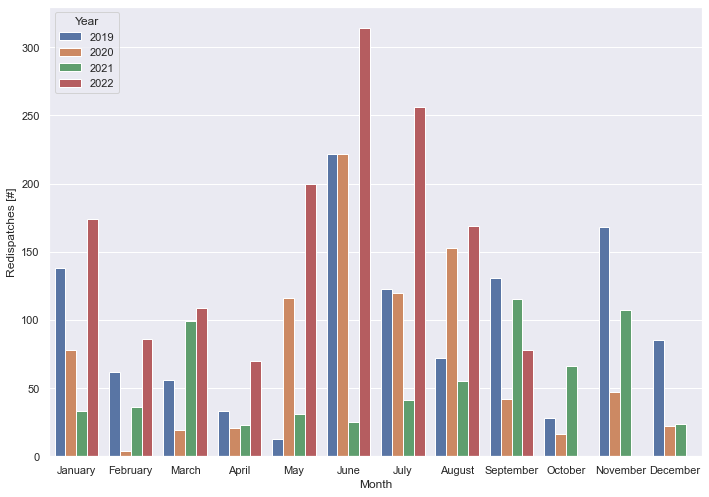

In [14]:
months = month_name[1:]

ax = sns.barplot(x="Month", y="Energie", hue="Year", data=tdf)
ax.set(xlabel='Month', ylabel='Redispatches [#]')
ax.set_xticks(range(12))
ax.set(xticklabels=months)

#### Trying some heat maps
Just an experiment to try to visualise the results better than in tabular form or box. Rather than focusing on the redisplaches per month in form of a messy bar plot, maybe a heatmap is a good solution.

In [15]:
alt_df = df.groupby(['Beschreibung', 'YM'])['Energie'].count().reset_index()
a_pivot = pd.pivot_table(alt_df, values='Energie', index='Beschreibung', columns='YM')

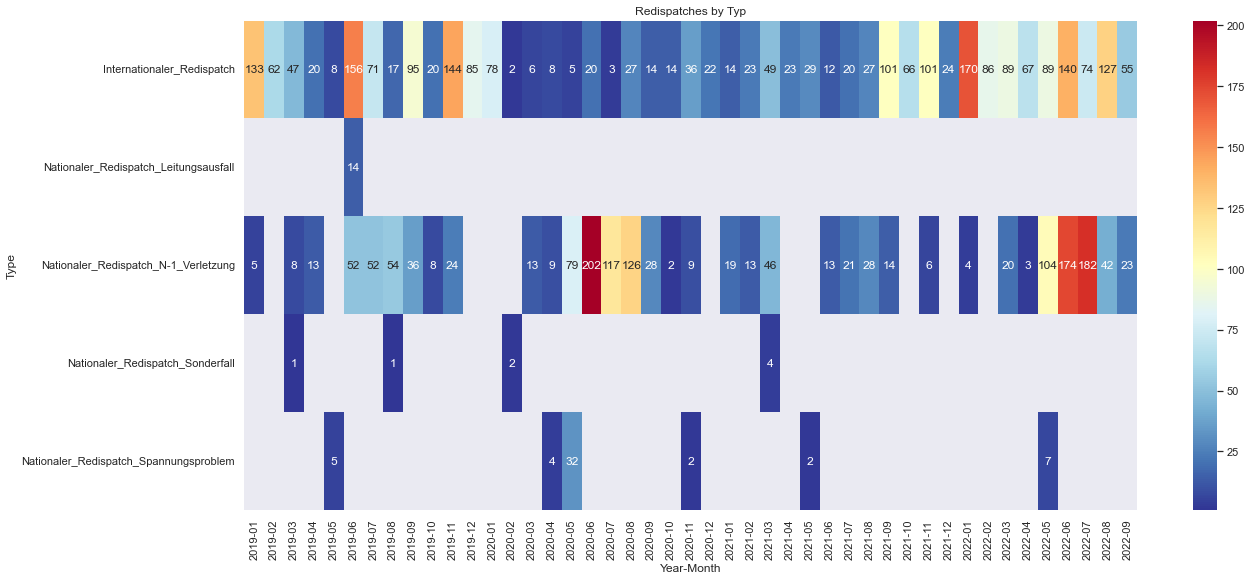

In [16]:
plt.figure(figsize = (20,9))
plt.title('Redispatches by Typ')

sns.heatmap(a_pivot, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.xlabel('Year-Month')
plt.ylabel('Type')
plt.show()

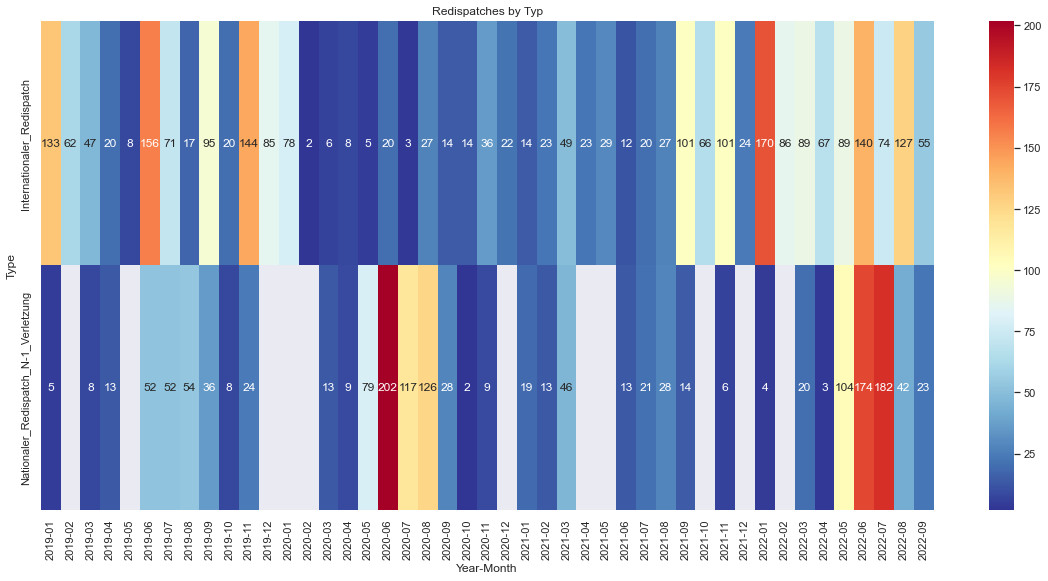

In [17]:
#Dropping the columns with little cases
a_new = a_pivot.drop(['Nationaler_Redispatch_Leitungsausfall', 'Nationaler_Redispatch_Sonderfall', 'Nationaler_Redispatch_Spannungsproblem'])

plt.figure(figsize = (20,9))
plt.title('Redispatches by Typ')

sns.heatmap(a_new, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.xlabel('Year-Month')
plt.ylabel('Type')
plt.show()

#### Units

Analyzing the units individually to gather more insights into the evolution over the last years

In [18]:
types = df['Beschreibung'].unique()
subdf = df[df['Beschreibung']==types[0]]

comparison = subdf.groupby(['EZE', 'Richtung']).count()['Energie'].sort_index(level=0)
comparison

EZE               Richtung             
AKW-AS            EZE Leistung erhöhen       8
BIEUDRON-AS       EZE Leistung absenken     43
                  EZE Leistung erhöhen     115
BITSCH-AS         EZE Leistung absenken     19
                  EZE Leistung erhöhen       8
CKW-FMM-SDL---AS  EZE Leistung absenken     23
                  EZE Leistung erhöhen      46
EGL-EKW-SDL---AS  EZE Leistung absenken     20
                  EZE Leistung erhöhen       8
EGL-KWM-SDL---AS  EZE Leistung absenken     12
                  EZE Leistung erhöhen      15
EGL-OIM-SDL---AS  EZE Leistung absenken      4
                  EZE Leistung erhöhen       2
KHR-AS            EZE Leistung absenken     14
                  EZE Leistung erhöhen      51
KLL-AS            EZE Leistung absenken     21
                  EZE Leistung erhöhen      73
KSL-MAPRAGG-AS    EZE Leistung absenken     36
                  EZE Leistung erhöhen      53
KVR-AS            EZE Leistung absenken     11
                  EZ

In [19]:
types = df['Beschreibung'].unique()
subdf = df[df['Beschreibung']==types[0]]

comparison = subdf.groupby(['EZE', 'Richtung', 'Year']).count()['Energie'].sort_index(level=0)
small_comp = comparison[comparison >20]
small_comp.to_csv('comp_EZE.csv')

In [20]:
comparison[comparison >20]

EZE               Richtung               Year
BIEUDRON-AS       EZE Leistung absenken  2019     37
                  EZE Leistung erhöhen   2019     61
                                         2022     35
CKW-FMM-SDL---AS  EZE Leistung erhöhen   2019     32
KHR-AS            EZE Leistung erhöhen   2022     26
KLL-AS            EZE Leistung absenken  2019     21
                  EZE Leistung erhöhen   2019     26
                                         2021     21
KSL-MAPRAGG-AS    EZE Leistung absenken  2019     33
KW-BLENIO-AS      EZE Leistung erhöhen   2022     21
KW-ROBIEI-AS      EZE Leistung absenken  2019     39
KWO-HANDECK-AS    EZE Leistung absenken  2019     27
                  EZE Leistung erhöhen   2019     32
KWO-INNERTKIR-AS  EZE Leistung absenken  2019     29
                  EZE Leistung erhöhen   2019     28
PKW-NANTDRANC-AS  EZE Leistung erhöhen   2022     21
PKW-VEYTAUX2-AS   EZE Leistung absenken  2019     31
PSKW-LIMMERN-AS   EZE Leistung absenken  2019     44


## Building the Cumsum
Biulding the cumulative sum over the dataframe. The dataset consists of eventy, hence unevenly spread events over the year. The cumsum of the redispatches is built summing up the redispatched energy on a daily basis, then building the cumsum over the whole year. If there are dates with no redispatch measures, the missing values are filled with the values from the last date with a value (forward filled)

In [21]:
def get_cumsum_per_year(df):
    '''
    Returns the cumsum per Year for any number of years for the column 'Energie'.
    
    input:
            df: Pandas DataFrame containing the column "Energie"
    output:
            return_df: Pandas Dataframe consisting of each date in the period of df. The missing values are forward filled. 

    '''
    
    single_day_df = df.groupby('Datum').sum().reset_index()
    single_day_df['Year'] = single_day_df.Datum.dt.year
    nyears = single_day_df['Year'].unique()
    
    single_day_df['yearly_cumsum'] = single_day_df.groupby(pd.Grouper(key="Datum", freq="Y"))['Energie_rel'].cumsum()
    
    single_day_df = single_day_df.set_index(['Datum'])
    cs = single_day_df['yearly_cumsum']
    
    fy = nyears[0]
    ly = nyears[-1]
    
    equal_idx = pd.date_range(date(fy,1,1),date(ly,10,1)-timedelta(days=1),freq='d')
    cs = cs.reindex(equal_idx, fill_value=np.nan)
    
    return_df = pd.DataFrame(cs)
    return_df.index.name = "Datum"
    return_df = return_df.reset_index()
    return_df['Year'] = return_df.Datum.dt.year
    
    final_cumsum = np.array([])
    nyears = return_df['Year'].unique()

    for y in nyears:
        subdf = return_df[return_df['Year'] == y]
        subdf = subdf.fillna(method='ffill').fillna(value=0)
        final_cumsum = np.append(final_cumsum, subdf['yearly_cumsum'].values, axis=0)

    return_df['yearly_cumsum'] = final_cumsum
    return_df['Date'] = return_df['Datum'].dt.strftime('%m-%d')
    return return_df


#### The Cumsum visualized
We can look at the international redispatches and the national ones. It needs to be noted for the national redispatches.

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Cumulative Int. Redispatch [MWh]')]

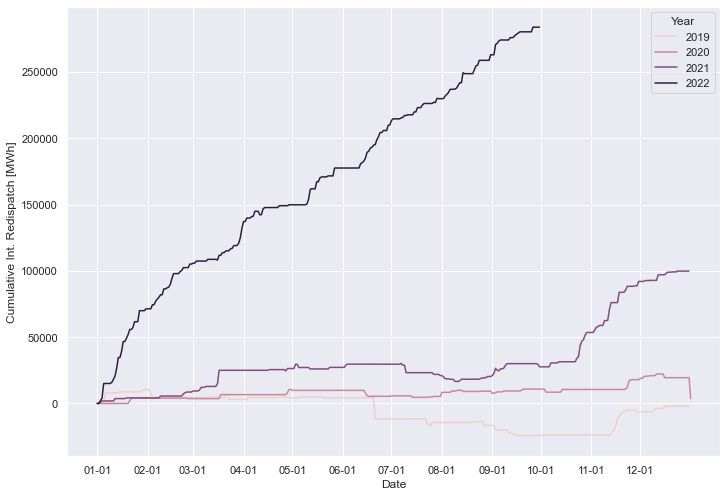

In [22]:
#Internationaler Redispatch

tdf = get_cumsum_per_year(df)

ax = sns.lineplot(x="Date", y="yearly_cumsum", hue="Year", data=tdf)
ax.set(xticks=[0, 31, 59,90,120,151,181,212,243,273,304,334])
ax.set(xlabel='Date', ylabel='Cumulative Int. Redispatch [MWh]')

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Cumulative Nat. Redispatch [MWh]')]

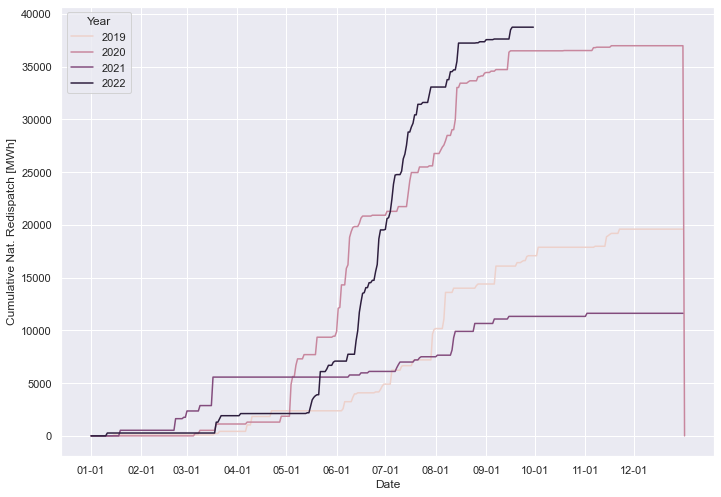

In [23]:
#Nationaler Redispatch 
types = df['Beschreibung'].unique()
subdf = df[df['Beschreibung']==types[1]]
subdf = subdf[subdf['Richtung'] == 'EZE Leistung erhöhen']

tdf = get_cumsum_per_year(subdf)

ax = sns.lineplot(x="Date", y="yearly_cumsum", hue="Year", data=tdf)
ax.set(xticks=[0, 31, 59,90,120,151,181,212,243,273,304,334])
ax.set(xlabel='Date', ylabel='Cumulative Nat. Redispatch [MWh]')

### Question 3: Will it get worse?

While it is hard to say how it evolves into the coming quarter, we can identify some trends over the last years.

#### Trend 1
Usually, most of the national redispatches happen during summer. This can have a multitude of reasons. First, the capacity in the summer is due to the higher temperatures a little less. Second, more fluctuations due to more renewables. But! 3.75 years is not enough to make a reliable call for the next 10 years.

#### Trend 2
International redispatches are on the rise. Since last October (October 21) we can clearly see a lot more redispatches. To definitely answer this questions, more data and especially from different sources are needed to test different hypotheis. One possible explenation is the exploitation of renewables in germany growing much faster than swiss renewables. This also helps answer the first question :) With the current number of redispatches we can clearly see an important trend. For the next years, the EU might need swissgrid to strengthen the grid. However, this does not mean, that switzerland and swissgrid are needed indefinitely.